# Conditioning and Stability

Natasha Watkins

In [1]:
import numpy as np
import scipy.linalg
from scipy.linalg import norm, qr, solve_triangular
from sympy import poly_from_expr, product, symbols, integrate, exp, N, subfactorial, factorial
from mpmath import e
import matplotlib.pyplot as plt

### Problem 1

In [2]:
def cond(A):
    σ = scipy.linalg.svdvals(A)
    if σ.min() == 0:
        return np.inf
    else:
        return σ.max() / σ.min()

In [3]:
A = np.random.random((3, 3))

In [4]:
cond(A)

22.786875481542918

In [5]:
np.linalg.cond(A)

22.786875481542918

In [6]:
B = np.eye(5)

In [7]:
cond(B)

1.0

### Problem 2

In [8]:
def experiment(n):
    
    w_roots = np.arange(1, n)
    
    x, i = symbols('x i')
    w = poly_from_expr(product(x-i, (i, 1, n-1)))[0]
    w_coeffs = np.array(w.all_coeffs())
    
    plt.figure(figsize=(10, 7))
    plt.plot(w_roots, np.zeros(n-1), 'o', label='Original')
    
    for i in range(100):
        r = np.random.normal(loc=1, scale=1e-10, size=n)

        new_coeffs = w_coeffs * r
        new_roots = np.roots(np.poly1d(new_coeffs))

        w_roots = np.sort(w_roots)
        new_roots = np.sort(new_roots)

        plt.scatter(new_roots.real, new_roots.imag, marker='.', c='k', s=2)
        
    print(f'The absolute condition number in the infinity norm is {norm(new_roots - w_roots, np.inf) / norm(r):.2f}')
    print(f'The relative condition number in the infinity norm is {norm(w_roots, np.inf) / norm(new_roots, np.inf):.2f}')
    
        
    plt.xlabel('Real axis')
    plt.ylabel('Imaginary axis')
    plt.legend(['Original', 'Perturbed'], loc='upper left')
    plt.show()

The absolute condition number in the infinity norm is 0.86
The relative condition number in the infinity norm is 0.94


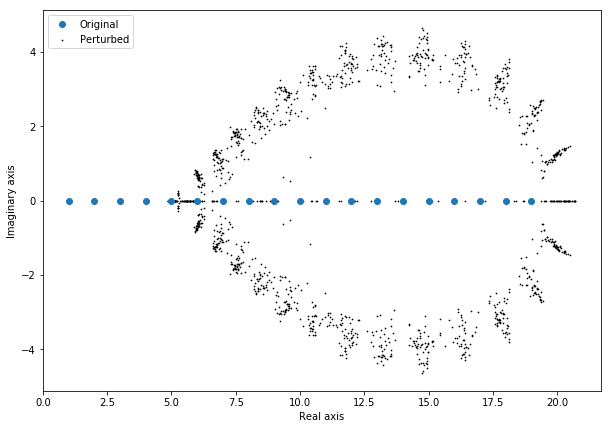

In [9]:
experiment(20)

### Problem 3

In [10]:
def cond_eigen(A):
    reals = np.random.normal(0, 1e-10, A.shape)
    imags = np.random.normal(0, 1e-10, A.shape)
    H = reals + 1j * imags
    λ = scipy.linalg.eigvals(A)
    λ_hat = scipy.linalg.eigvals(A + H)
    abs_cond = norm(λ - λ_hat) / norm(H)
    rel_cond = (norm(A)/norm(λ)) * abs_cond
    return abs_cond, rel_cond

In [11]:
cond_eigen(A)

(1.346964711606196, 1.4700361571575205)

### Problem 4

In [12]:
def rel_plot(xmin, xmax, ymin, ymax, res):
    
    grid_x = np.linspace(xmin, xmax, res)
    grid_y = np.linspace(ymin, ymax, res)
    
    x, y = np.meshgrid(grid_x, grid_y)
    rel_conds = np.empty((res, res))
    
    for i, x_i in enumerate(grid_x):
        for j, y_i in enumerate(grid_y):
            A = np.array([[1,  x_i], 
                          [y_i, 1]])
            rel_conds[i, j] = cond_eigen(A)[1]
                                
    plt.pcolormesh(x, y, rel_conds, cmap='gray_r')
    plt.colorbar()
    
    plt.show()

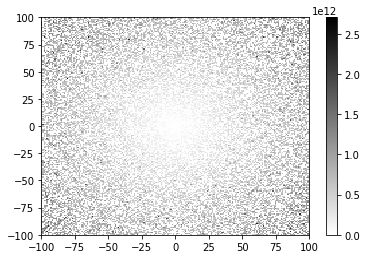

In [13]:
rel_plot(-100, 100, -100, 100, 200)

### Problem 5

In [14]:
def fit_polynomial(n):   
    
    xk, yk = np.load('stability_data.npy').T
    A = np.vander(xk, n+1)
    
    x_inv = scipy.linalg.inv(A.T @ A) @ A.T @ yk
    error_inv = norm(A @ x_inv - yk)
    
    print(f'The inverse method has a forward error of {error_inv:.2f}')
    
    Q, R = qr(A, mode='economic')
    x_qr = solve_triangular(R, Q.T @ yk)
    error_qr = norm(A @ x_qr - yk)
    
    print(f'The QR method has a forward error of {error_qr:.2f}')
    
    plt.figure(figsize=(10, 6))
    plt.plot(xk, np.polyval(x_inv, xk), label='Normal equations')
    plt.plot(xk, np.polyval(x_qr, xk), label='QR Solver')
    plt.plot(xk, yk, '.', c='k')
    plt.legend()
    plt.show()

The inverse method has a forward error of 71.58
The QR method has a forward error of 4.53


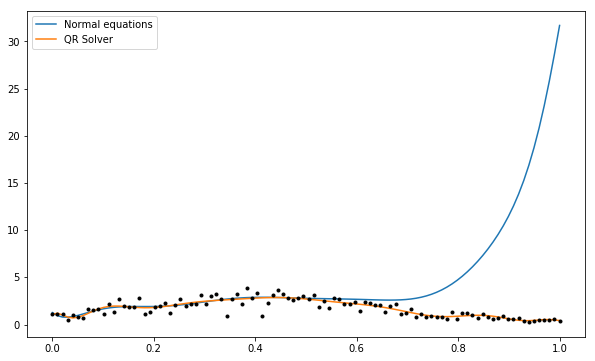

In [15]:
fit_polynomial(15)

### Problem 6

In [44]:
def forward_error():
    
    x = symbols('x')
    n_list = np.arange(5, 50, 5)
    
    errors = np.empty(10)
    
    for i, n in enumerate(n_list):
        integral = N(integrate(x**n * exp(x-1), (x, 0, 1)))
        sf = (-1)**n * subfactorial(n) + (-1)**(n+1) * factorial(n) / e
        errors[i] = np.abs(integral - sf)
        
    plt.plot(np.log(errors))
    plt.show()

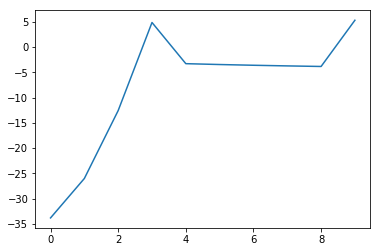

In [45]:
forward_error()